In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
from dotenv import dotenv_values
from elasticsearch import Elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
#CLASSIFICATION_PATH = Path('classification_20211010_135831_84_227e.tif')
CLASSIFICATION_PATH = Path('classification_20211003_161639_91_241d.tif')

In [3]:
planet_id = CLASSIFICATION_PATH.stem[15:]
planet_id

'20211010_135831_84_227e'

# Out Paths

In [4]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True)

class_dir = out_dir / planet_id
class_dir.mkdir(exist_ok=True, parents=True)

# Load Hand Edited Dataset

In [5]:
with rasterio.open(CLASSIFICATION_PATH) as ds:
    X_val = ds.read(1).astype(np.float32)
    p_val = ds.profile
    bounds_val = ds.bounds

    
val_mask = (X_val < 0) | (X_val == 255) | (X_val == 9) 
X_val[X_val < 0] = -1 
X_val[X_val == 255] = -1
    
p_val

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3704, 'height': 3662, 'count': 1, 'crs': CRS.from_epsg(32720), 'transform': Affine(3.0, 0.0, 290598.0,
       0.0, -3.0, 8761221.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

<AxesSubplot:>

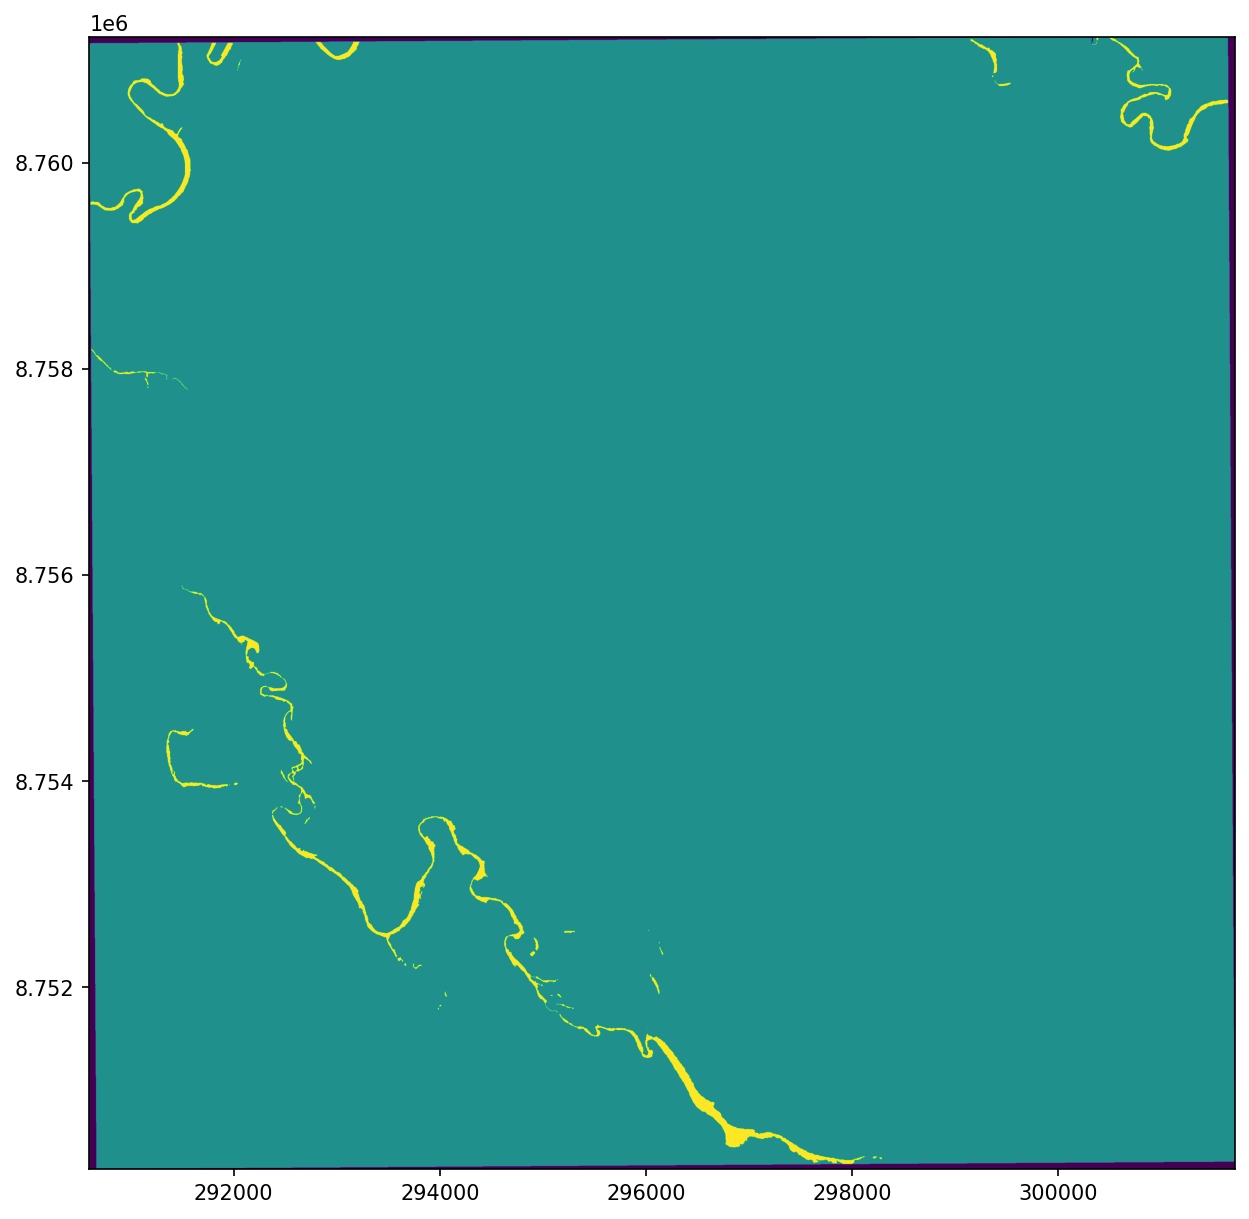

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
show(X_val, transform=p_val['transform'], ax=ax)

# Get DSWx Dataset

## Elastic Search bookkeeping

My `.env` file would look like

```
ES_USERNAME=<JPL_USERNAME>
ES_PASSWORD=<JPL_PASSWORD>
```

In [7]:
config = dotenv_values()
ES_USERNAME = config['ES_USERNAME']
ES_PASSWORD = config['ES_PASSWORD']

In [8]:
GRQ_URL = 'https://100.104.62.10/grq_es/'
grq_client = Elasticsearch(GRQ_URL, 
                           http_auth=(ES_USERNAME, ES_PASSWORD), 
                           verify_certs=False, 
                           read_timeout=50000, 
                           terminate_after=2500,
                          )
grq_client.ping()

/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://100.104.62.10:443 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


True

In [9]:
search = Search(using=grq_client, 
                # wildcard is where the version is
                index='grq_*_l3_dswx_hls')

def _get_urls(data: dict) -> list:
    base_url = data['browse_urls'][0]
    base_url = base_url.replace('s3-website-us-west-2', 's3.us-west-2').replace('browse', 'products')
    all_file_names = [file_data['FileName'] for file_data in data['metadata']['Files']]
    
    urls = [f'{base_url}/{file_name}' for file_name in all_file_names]
    urls = [url.replace('http://', 'https://') for url in urls]

    return urls

def get_DSWX_doc(hls_id: str) -> dict:
    tokens = HLS_ID.split('.')
    token_1 = tokens[2]
    token_2 = tokens[3]
    
    q_qs = Q('query_string', 
             query=f'\"{token_1}\" \"{token_2}\"', 
             default_field="id")
    
    query = search.query(q_qs)
    resp = query.execute()
    n = len(resp.hits)
    
    if n > 1:
        raise ValueError('Multiple DSWx Products for current query')
    
    if n == 0:
        raise ValueError('No DSWx products match HLS ID')
    data = resp.hits[0].to_dict()
    return data

def get_DSWx_urls(hls_id: str) -> list:
    doc = get_DSWX_doc(hls_id)
    return _get_urls(doc)

# Chips

In [10]:
df_site= gpd.read_file('s3://opera-calval-database-dswx/site.geojson')
df_site.head()

,site_name,water_content,geometry
0,3_42,3.0,"POLYGON ((-122.95236 57.91514, -122.78589 57.9..."
1,4_21,4.0,"POLYGON ((-72.05120 55.21516, -71.89605 55.215..."
2,2_8,2.0,"POLYGON ((-70.87008 -52.06500, -70.72517 -52.0..."
3,4_3,4.0,"POLYGON ((33.56456 -16.33480, 33.56454 -16.245..."
4,4_34,4.0,"POLYGON ((-96.70081 62.77517, -96.57702 62.775..."


## Collacated HLS ID

In [11]:
df_dswx= gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_dswx.head()

,cloud_cover,collocated_dswx,datetime,image_name,instrument,provider,resolution,s3_bucket,s3_key_image,site_coverage,site_name,timeDelta_days,geometry
0,0.0,HLS.S30.T22KGE.2021282T133229.v2.0,2021-10-09 12:39:44,20211009_123944_46_2212,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/2_13/20211009_123944_46_2212/20211009_123...,82.409823,2_13,0.040089,"POLYGON ((-49.22010 -18.47171, -49.25746 -18.6..."
1,0.0,HLS.S30.T55TCJ.2021271T010651.v2.0,2021-09-28 01:06:12,20210928_010612_93_2424,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/4_5/20210928_010612_93_2424/20210928_0106...,14.555879,4_5,0.006154,"POLYGON ((144.94479 43.97568, 144.88627 43.782..."
2,0.0,HLS.L30.T41TMN.2021301T064037.v2.0,2021-10-28 05:51:09,20211028_055109_45_245f,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/2_6/20211028_055109_45_245f/20211028_0551...,98.218700,2_6,0.034358,"POLYGON ((62.89599 47.37032, 62.83030 47.17890..."
3,0.0,HLS.L30.T13VDF.2021285T180913.v2.0,2021-10-12 17:35:55,20211012_173555_20_2276,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/4_20/20211012_173555_20_2276/20211012_173...,64.450386,4_20,0.023128,"POLYGON ((-105.67707 59.39304, -105.77853 59.2..."
4,0.0,HLS.S30.T47VPG.2021261T042711.v2.0,2021-09-18 04:25:59,20210918_042559_64_2419,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/2_24/20210918_042559_64_2419/20210918_042...,97.830115,2_24,0.004040,"POLYGON ((101.69577 60.00023, 101.58257 59.812..."


In [12]:
df_planet_image = df_dswx[df_dswx.image_name == planet_id].reset_index()
df_planet_image

,index,cloud_cover,collocated_dswx,datetime,image_name,instrument,provider,resolution,s3_bucket,s3_key_image,site_coverage,site_name,timeDelta_days,geometry
0,5,0.0,HLS.S30.T20LKN.2021283T143729.v2.0,2021-10-10 13:58:31,20211010_135831_84_227e,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/3_8/20211010_135831_84_227e/20211010_1358...,96.820322,3_8,0.032946,"POLYGON ((-64.96109 -11.14220, -64.99808 -11.3..."


In [13]:
df_chip = df_site[df_site.site_name == df_planet_image.site_name[0]].reset_index(drop=True)
df_chip.geometry = df_chip.geometry.buffer(.01)
df_chip

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_21793/2484588055.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_chip.geometry = df_chip.geometry.buffer(.01)


,site_name,water_content,geometry
0,3_8,3.0,"POLYGON ((-64.92322 -11.20520, -64.92317 -11.2..."


In [14]:
HLS_ID = df_planet_image.collocated_dswx[0]
HLS_ID

'HLS.S30.T20LKN.2021283T143729.v2.0'

In [15]:
urls = get_DSWx_urls(HLS_ID)
urls

/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


['https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001_B01_WTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001_B02_BWTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001_B03_CONF.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001/OPERA_L3_DSWx_HLS_S2B_30_T20LKN_20211010T143729Z_20220811T032302Z_v0.1_001_B04_DIAG.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS

# Visualize!

In [16]:
with rasterio.open(urls[0]) as ds:
    X_dswx = ds.read(1)
    t = ds.tags()
    d = ds.descriptions
    p_dswx = ds.profile
    
t

{'ACCODE': 'LaSRC',
 'AREA_OR_POINT': 'Area',
 'CLOUD_COVERAGE': '14',
 'DEM_FILE': '(not provided)',
 'HLS_DATASET': 'HLS.S30.T20LKN.2021283T143729.v2.0',
 'LANDCOVER_FILE': '(not provided)',
 'LEVEL': '3',
 'MEAN_SUN_AZIMUTH_ANGLE': '79.2991179065451',
 'MEAN_SUN_ZENITH_ANGLE': '20.6854354942319',
 'MEAN_VIEW_AZIMUTH_ANGLE': '260.934676133384',
 'MEAN_VIEW_ZENITH_ANGLE': '4.37811878066163',
 'NBAR_SOLAR_ZENITH': '23.4291969400083',
 'PROCESSING_DATETIME': '2022-08-11T03:23:02',
 'PRODUCT_ID': 'dswx_hls',
 'PRODUCT_SOURCE': 'HLS',
 'PRODUCT_TYPE': 'DSWx',
 'PRODUCT_VERSION': '0.1',
 'PROJECT': 'OPERA',
 'SENSING_TIME': '2021-10-10T14:45:58.378503Z',
 'SENSOR': 'MSI',
 'SENSOR_PRODUCT_ID': 'S2B_MSIL1C_20211010T143729_N0301_R096_T20LKN_20211010T180754.SAFE',
 'SPACECRAFT_NAME': 'SENTINEL-2B',
 'SPATIAL_COVERAGE': '99',
 'WORLDCOVER_FILE': '(not provided)'}

In [17]:
def modify_dswx(X):
    """Old version: 
    not water (0), water with high confidence (1), water with moderate confidence 
    (2), potential wetland (3), and low confidence water (4). """
    
    X_new = X.copy()
    X_new[(X == 1) | (X == 2)] = 1
    X_new[(X == 3) | (X == 4)] = 2
    return X_new

In [18]:
X_dswx_v4 = modify_dswx(X_dswx)

<AxesSubplot:>

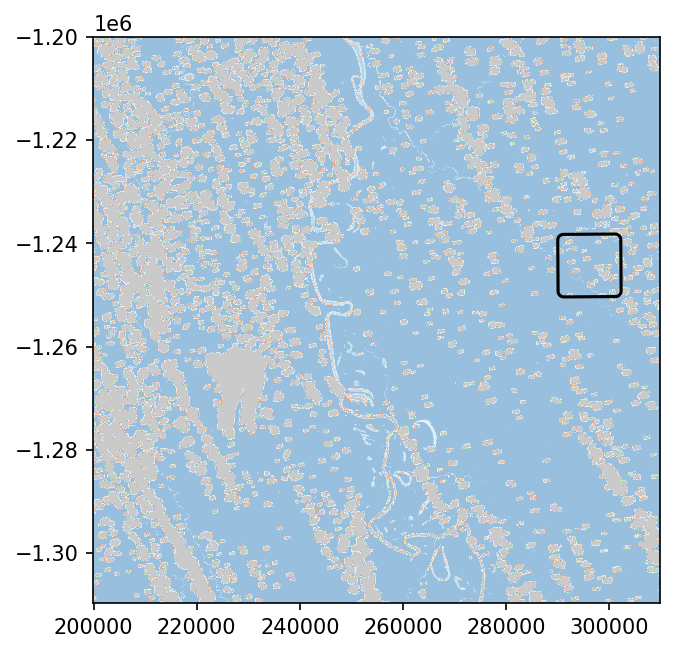

In [19]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))

show(X_dswx_v4, transform=p_dswx['transform'], cmap='tab20c', vmax=10, alpha=.5, ax=ax)
df_chip.to_crs(p_dswx['crs']).boundary.plot(ax=ax, color='black')

<AxesSubplot:>

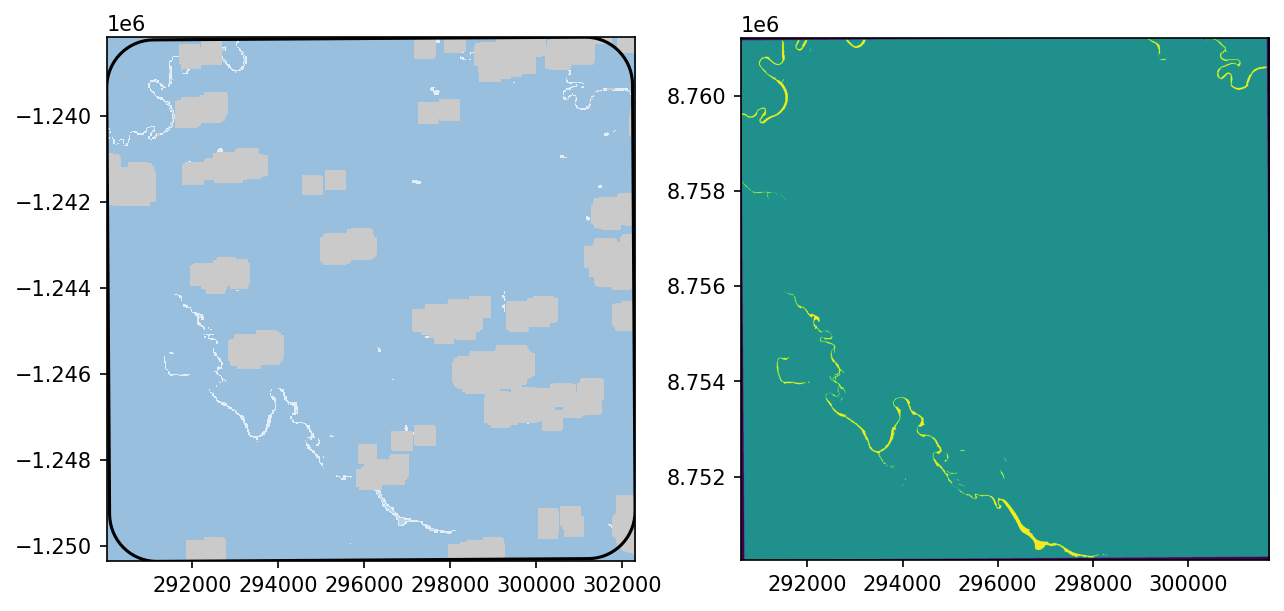

In [20]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

df_temp = df_chip.to_crs(p_dswx['crs'])
xmin, ymin, xmax, ymax = df_temp.total_bounds

show(X_dswx_v4, transform=p_dswx['transform'], cmap='tab20c', vmin=0, vmax=10, alpha=.5, ax=ax[0], interpolation='none')
df_temp.boundary.plot(ax=ax[0], color='black')

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)

show(X_val, transform=p_val['transform'], ax=ax[1])

# Compare

In [21]:
from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_match_profile

In [22]:
p_val['crs']

CRS.from_epsg(32720)

In [23]:
p_dswx['crs']

CRS.from_wkt('PROJCS["UTM Zone 20, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [24]:
X_dswx_cropped, dswx_profile_cropped = read_raster_from_window(urls[0],
                                                               list(df_chip.total_bounds),
                                                               df_chip.crs
                                                               )

X_dswx_cropped_v4 = modify_dswx(X_dswx_cropped)

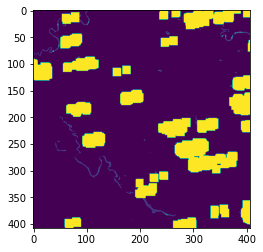

In [25]:
plt.imshow(X_dswx_cropped_v4)

In [26]:
dswx_profile_cropped

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 406, 'height': 408, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 20, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 290070.0,
       0.0, -30.0, -1238160.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [27]:
X_val_new = X_val.copy()

X_val_new[X_val < 0] = np.nan

# modify so it can be reprojected
p_val['nodata'] = np.nan
p_val['dtype'] = np.float32

X_val_repr, p_r = reproject_arr_to_match_profile(X_val_new, p_val, dswx_profile_cropped, resampling='bilinear')
X_val_repr = X_val_repr[0, ...]

In [28]:
with rasterio.open(class_dir / f'percent_surface_water_{planet_id}.tif', 'w', **p_r) as ds:
    ds.write(X_val_repr, 1)

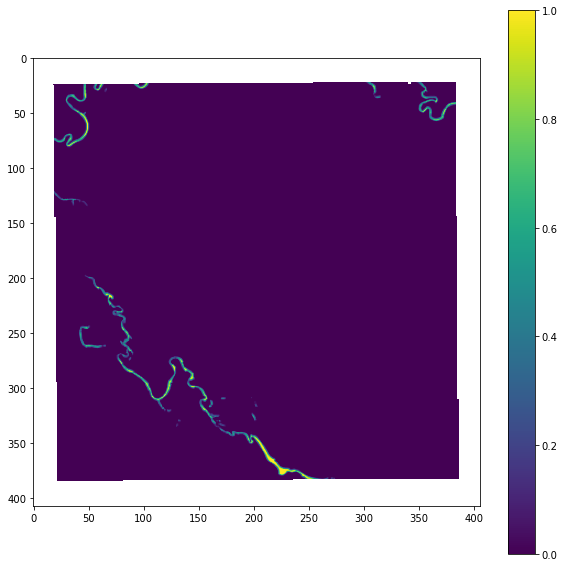

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(X_val_repr)
plt.colorbar()

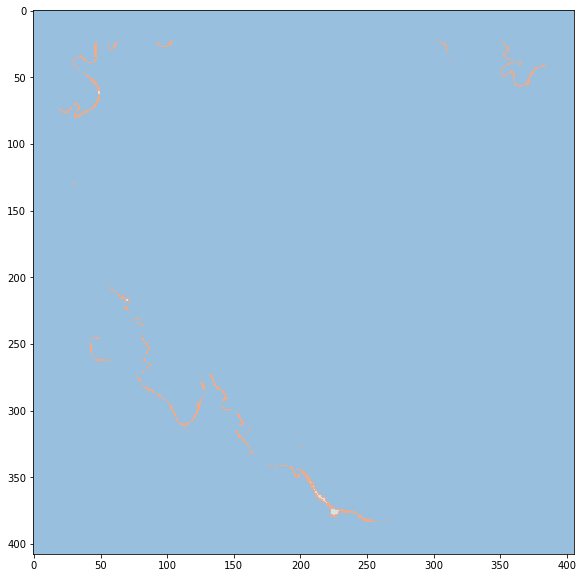

In [30]:
X_val_class = np.zeros(X_val_repr.shape)

X_val_class[X_val_repr == 1] = 1 
X_val_class[(X_val_repr >= .5) & (X_val_repr < 1)] = 2


plt.figure(figsize=(10, 10))

plt.imshow(X_val_class, cmap='tab20c', vmin=0,  vmax=10, alpha=.5, interpolation='none')

# Evaluate

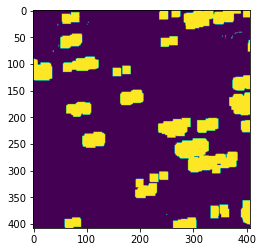

In [31]:
dswx_mask = np.isin(X_dswx_cropped_v4, [9, 255])
plt.imshow(dswx_mask)

## Confusion Matrix

In [32]:
comparison_mask = (dswx_mask) | (np.isnan(X_val_class))

y_dswx = X_dswx_cropped_v4[~comparison_mask]
y_val = X_val_class[~comparison_mask]

In [33]:
class_dict = {0: 'not_water',
              1: 'surface_water', 
              2: 'partial_surface_water'}

In [34]:
y_dswx_str = pd.Series([class_dict[class_id] for class_id in y_dswx], name='OPERA DSWx')
y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='OPERA Validation')
df_conf = pd.crosstab(y_val_str, y_dswx_str)
df_conf

OPERA DSWx,not_water,partial_surface_water,surface_water
OPERA Validation,,,
not_water,138133,651,19
partial_surface_water,44,636,56
surface_water,0,4,36


## Prec/Recall Per Class

In [35]:
conf_arr = np.array(df_conf)
recall_per_class_val = conf_arr.diagonal() / conf_arr.sum(axis=1)
recall_per_class_val

array([0.99517301, 0.86413043, 0.9       ])

In [36]:
recall_per_class = {x: y for (x, y) in zip(df_conf.index.values, recall_per_class_val)}
recall_per_class

{'not_water': 0.9951730149924713,
 'partial_surface_water': 0.8641304347826086,
 'surface_water': 0.9}

In [37]:
conf_arr = np.array(df_conf)
prec_per_class_val = conf_arr.diagonal() / conf_arr.sum(axis=0)
prec_per_class_val

array([0.99968157, 0.49264136, 0.32432432])

In [38]:
prec_per_class = {x: y for (x, y) in zip(df_conf.index.values, prec_per_class_val)}
prec_per_class

{'not_water': 0.999681567844142,
 'partial_surface_water': 0.49264136328427577,
 'surface_water': 0.32432432432432434}

## Accuracy per class

In [39]:
acc_per_class = {}

for c in [0, 1, 2]:
    y_val_temp = y_val.copy()
    y_dswx_temp = y_dswx.copy()
    
    y_val_temp[y_val_temp != c] = 255
    y_dswx_temp[y_dswx_temp != c] = 255

    acc_per_class[c] = (y_val_temp == y_dswx_temp).sum() / y_dswx.size

acc_per_class

{0: 0.9948846173134928, 1: 0.9994340122797842, 2: 0.9945908768511023}

## Total Accuracy

In [40]:
(y_dswx == y_val).sum() / y_val.size

0.9944547532221896

## Additional Metrics

Different metrics for each class (see class dict above) in order of class value, using sklearn.

In [41]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, supp = precision_recall_fscore_support(y_val, y_dswx)
prec, rec, f1, supp

(array([0.99968157, 0.32432432, 0.49264136]),
 array([0.99517301, 0.9       , 0.86413043]),
 array([0.9974222 , 0.47682119, 0.62752837]),
 array([138803,     40,    736]))

For example, the last row is count per class based on validation data.

In [42]:
(y_val == 0).sum()

138803